# 퀘스트

Fashion MNIST 데이터셋에 대한 분류기를 만들고자 합니다.

입력값을 총 10개의 클래스로 분류하고자 하며, input_shape는 (28,28)이어야 합니다.

## import

필요한 모듈을 import 해주세요!!!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

## 전처리

Fashion MNIST 데이터 셋은 `tf.keras.datasets.fashion_mnist`로 불러올 수 있습니다.

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

데이터 셋을 불러와, train/validation set을 구성해줍니다.

In [3]:
(x_train, y_train), (x_valid, y_valid) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


정상적으로 로드 되었는지 확인해볼까요? (train set과 validation set의 크기를 살펴봅시다 !)

In [4]:
x_train.shape, x_valid.shape

((60000, 28, 28), (10000, 28, 28))

In [5]:
y_train.shape, y_valid.shape

((60000,), (10000,))

데이터셋 시각화

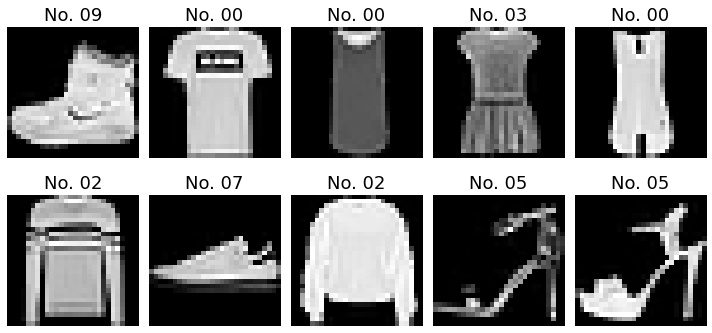

In [6]:
fig, axes = plt.subplots(2, 5)
fig.set_size_inches(10, 5)

for i in range(10):
    axes[i//5, i%5].imshow(x_train[i], cmap='gray')
    axes[i//5, i%5].set_title('No. %02d' % y_train[i], fontsize=18)
    plt.setp( axes[i//5, i%5].get_xticklabels(), visible=False)
    plt.setp( axes[i//5, i%5].get_yticklabels(), visible=False)
    axes[i//5, i%5].axis('off')

plt.tight_layout()
plt.show()

**이미지 정규화 (Normalization)**
* 모든 이미지 픽셀 값들을 0 ~ 1 사이의 값으로 정규화합니다.
* x_train, x_valid 에 대해서만 정규화해주도록 합니다

정규화 전의 최소값과 최대값을 확인합니다.

In [7]:
x_train.min(), x_train.max()

(0, 255)

In [8]:
# 정규화 코드
x_train = x_train / 255
x_valid = x_valid / 255

In [9]:
# 정규화 후 최소값/최대값 확인
x_train.min(), x_train.max()

(0.0, 1.0)

## 모델링

이제 Modeling 차례입니다.

`Sequential` 모델 안에서 층을 깊게 쌓아 올려 주면 됩니다.

1. Dense 레이어는 2D 형태의 데이터를 받아들이지 못합니다. Flatten 레이어로 2D -> 1D로 변환해주세요
2. 깊은 출력층과 더 많은 Layer를 쌓습니다.
3. Dense Layer에 `activation='relu'`를 적용합니다.
4. 분류(Classification)의 마지막 층의 출력 숫자는 분류하고자 하는 클래스 갯수와 **같아야** 합니다.


In [10]:
tf.keras.backend.set_floatx('float64')
x_train.shape

(60000, 28, 28)

In [11]:
x = Flatten(input_shape=(28, 28))
print(x(x_train).shape)

(60000, 784)


In [12]:
model = Sequential([
    # Flatten으로 shape 펼치기, input_shape는 (28, 28)로 지정합니다.
    Flatten(input_shape=(28, 28)),
    # Dense Layer
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    # Classification을 위한 Softmax 
    # 출력층의 갯수는 클래스의 갯수와 동일하게 맞춰줍니다 (10개), activation도 잊지마세요!
    Dense(10, activation='softmax')
])

In [13]:
# 모델 요약
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                3

## 컴파일(compile)

1. `optimizer`는 가장 최적화가 잘되는 알고리즘인 'adam'을 사용합니다.
2. `loss`는 무엇을 지정하면 좋을까요? (`categorical_crossentropy` / `sparse_categorical_crossentropy`)
3. `metrics`를 'acc' 혹은 'accuracy'로 지정하면, 학습시 정확도를 모니터링 할 수 있습니다.

In [14]:
#원핫인코딩 체크
y_train[0]

9

In [15]:
#원핫인코딩이 안되어있다. loss는 sparse_categorical_crossentropy로 설정
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

`val_loss` 기준으로 epoch 마다 최적의 모델을 저장하기 위하여, ModelCheckpoint를 만듭니다.
* `checkpoint_path`는 모델이 저장될 파일 명을 설정합니다.
* `ModelCheckpoint`을 선언하고, 적절한 옵션 값을 지정합니다.

In [16]:
checkpoint_path ="tmp_checkpoint.ckpt"
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

## 학습(fit)

1. `validation_data`를 반드시 지정합니다.
2. `epochs`을 적절하게 지정합니다.
3. `callbacks`에 바로 위에서 만든 checkpoint를 지정합니다.

In [17]:
history = model.fit(x_train, y_train, 
                    validation_data=(x_valid, y_valid),
                    epochs=20, callbacks=[checkpoint],
                    )

Epoch 1/20
1873/1875 [============================>.] - ETA: 0s - loss: 0.5055 - acc: 0.8184
Epoch 00001: val_loss improved from inf to 0.41327, saving model to tmp_checkpoint.ckpt
1875/1875 [==============================] - 22s 11ms/step - loss: 0.5053 - acc: 0.8185 - val_loss: 0.4133 - val_acc: 0.8517
Epoch 2/20
1872/1875 [============================>.] - ETA: 0s - loss: 0.3721 - acc: 0.8635
Epoch 00002: val_loss improved from 0.41327 to 0.39177, saving model to tmp_checkpoint.ckpt
1875/1875 [==============================] - 22s 12ms/step - loss: 0.3720 - acc: 0.8635 - val_loss: 0.3918 - val_acc: 0.8597
Epoch 3/20
1871/1875 [============================>.] - ETA: 0s - loss: 0.3388 - acc: 0.8764
Epoch 00003: val_loss improved from 0.39177 to 0.35558, saving model to tmp_checkpoint.ckpt
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3389 - acc: 0.8763 - val_loss: 0.3556 - val_acc: 0.8726
Epoch 4/20
1875/1875 [==============================] - ETA: 0s - loss: 0.

In [18]:
#학습 완료 후 Load Weights
model.load_weights(checkpoint_path)

In [19]:
# 학습 후 검증
model.evaluate(x_valid, y_valid)

313/313 [==============================] - 1s 4ms/step - loss: 0.3226 - acc: 0.8918


[0.32257607214450834, 0.8918]